In [ ]:
import pandas as pd 
import matplotlib.pyplot as plt
import warnings
import requests
data_path = '../BindingDB_All.tsv'

## 1. Data Exploration

In [142]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", message=".*Specify dtype option on import or set low_memory=False.*")
    df = pd.read_csv(data_path, sep='\t', on_bad_lines='skip');
df.head()

,BindingDB Reactant_set_id,Ligand SMILES,Ligand InChI,Ligand InChI Key,BindingDB MonomerID,BindingDB Ligand Name,Target Name,Target Source Organism According to Curator or DataSource,Ki (nM),IC50 (nM),...,UniProt (SwissProt) Recommended Name of Target Chain.12,UniProt (SwissProt) Entry Name of Target Chain.12,UniProt (SwissProt) Primary ID of Target Chain.12,UniProt (SwissProt) Secondary ID(s) of Target Chain.12,UniProt (SwissProt) Alternative ID(s) of Target Chain.12,UniProt (TrEMBL) Submitted Name of Target Chain.12,UniProt (TrEMBL) Entry Name of Target Chain.12,UniProt (TrEMBL) Primary ID of Target Chain.12,UniProt (TrEMBL) Secondary ID(s) of Target Chain.12,UniProt (TrEMBL) Alternative ID(s) of Target Chain.12
0,1,O[C@@H]1[C@@H](O)[C@@H](Cc2ccccc2)N(CCCCCC(O)=...,InChI=1S/C31H42N2O7/c34-27(35)17-9-3-11-19-32-...,XGEGDSLAQZJGCW-HHGOQMMWSA-N,608734,"6-[(4R,5S,6S,7R)-4,7-dibenzyl-3-(5-carboxypent...",Dimer of Gag-Pol polyprotein [501-599],Human immunodeficiency virus 1,0.24,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,O[C@@H]1[C@@H](O)[C@@H](Cc2ccccc2)N(C\C=C\c2cn...,InChI=1S/C31H34N6O3/c38-29-27(17-23-9-3-1-4-10...,UZLMEAPBHYEHAC-UNTBESQGSA-N,22,"(4R,5S,6S,7R)-4,7-dibenzyl-5,6-dihydroxy-1,3-b...",Dimer of Gag-Pol polyprotein [501-599],Human immunodeficiency virus 1,0.25,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,O[C@@H]1[C@@H](O)[C@@H](Cc2ccccc2)N(CC2CC2)C(=...,InChI=1S/C29H34N4O3/c34-27-25(16-21-8-3-1-4-9-...,HYNYUFZPPJMPOB-UTWJFGBXSA-N,23,"(4R,5S,6S,7R)-4,7-dibenzyl-1-(cyclopropylmethy...",Dimer of Gag-Pol polyprotein [501-599],Human immunodeficiency virus 1,0.41,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,OCCCCCCN1[C@H](Cc2ccccc2)[C@H](O)[C@@H](O)[C@@...,InChI=1S/C29H40N2O4/c32-18-10-2-1-9-17-30-25(1...,YXVAZXDWVZTGGD-VIJSPRBVSA-N,24,"(4R,5S,6S,7R)-4,7-dibenzyl-1-(cyclopropylmethy...",Dimer of Gag-Pol polyprotein [501-599],Human immunodeficiency virus 1,0.8,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,OCCCCCN1[C@H](Cc2ccccc2)[C@H](O)[C@@H](O)[C@@H...,InChI=1S/C28H38N2O4/c31-17-9-3-8-16-29-24(18-2...,WWTSWTPNILRSJX-XDZXDJIYSA-N,25,"(4R,5S,6S,7R)-4,7-dibenzyl-1-(cyclopropylmethy...",Dimer of Gag-Pol polyprotein [501-599],Human immunodeficiency virus 1,0.99,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


After exploring the dataset, we have discovered something odd that we wanted to point out. Some proteins seem to have multiple possible sequences:

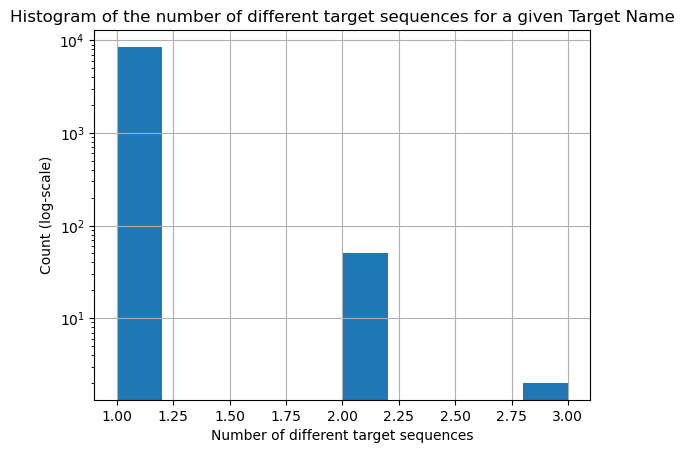

In [144]:
df.groupby(['Target Name', 'UniProt (SwissProt) Entry Name of Target Chain'])['BindingDB Target Chain Sequence'].apply(lambda x: len(x.unique())).hist(log=True)
plt.title('Histogram of the number of different target sequences for a given Target Name')
plt.ylabel('Count (log-scale)')
plt.xlabel('Number of different target sequences');

In [ ]:
df_grouped = df.groupby(['Target Name', 'UniProt (SwissProt) Entry Name of Target Chain'])['BindingDB Target Chain Sequence'].apply(lambda x: x.unique())
df_grouped = df_grouped[df_grouped.apply(len) >= 2].reset_index()
example = df_grouped[df_grouped['BindingDB Target Chain Sequence'].apply(lambda x: len(x[0])) < 100].sample(1)
print('Example of a problematic case:')
print('Target Name: ', example['Target Name'].values[0])
print('UniProt (SwissProt) Entry Name of Target Chain: ', example['UniProt (SwissProt) Entry Name of Target Chain'].values[0])
for idx, seq in enumerate(example['BindingDB Target Chain Sequence'].values[0]):
    print(f'Sequence {idx}: ', seq)

Example of a problematic case:
Target Name:  Histone H3.1 [22-45]
UniProt (SwissProt) Entry Name of Target Chain:  H31_HUMAN
Sequence 0:  ATKAARKSAPATGGVKKPHRYRPG
Sequence 1:  ATKAARKSAPATGGVKKPHRYRPGGK


## 2. Data Processing

Our study focuses on the impact of certain mutations and certain parts of protein sequences and try to understand the impact on binding affinity. We will thus retain certain features to have a more neat data file:
- the id of the interaction in BindingDB
- the Ligand SMILES
- the protein target Name
- the protein target chain sequence
- the entry name of the target chain in UniProt (SwissProt)
- binding affinity features

We first looked at how well defined binding affinity metrics are in BindingDB:

In [147]:
bindind_affinity_covariates = ['Ki (nM)', 'IC50 (nM)', 'Kd (nM)', 'EC50 (nM)', 'kon (M-1-s-1)', 'koff (s-1)']
for c in bindind_affinity_covariates:
    print(f"Missing {c} values rate: {df[[c]].isna().sum().values/len(df[[c]])}")

Missing Ki (nM) values rate: [0.79742492]
Missing IC50 (nM) values rate: [0.33105142]
Missing Kd (nM) values rate: [0.96203274]
Missing EC50 (nM) values rate: [0.9084931]
Missing kon (M-1-s-1) values rate: [0.99965635]
Missing koff (s-1) values rate: [0.99966318]


There are a lot of missing values and to retain as much data as possible, we have decided to focus on IC50 (nM) values since it is the most available one.

In [148]:
target_names = ['UniProt (SwissProt) Entry Name of Target Chain.{}'.format(i) for i in range(1,13)]
for t in target_names: 
    print(f"Missing values rate for {t}: ", df[[t]].isna().sum().values/len(df[[t]]))

Missing values rate for UniProt (SwissProt) Entry Name of Target Chain.1:  [0.94722317]
Missing values rate for UniProt (SwissProt) Entry Name of Target Chain.2:  [0.98783376]
Missing values rate for UniProt (SwissProt) Entry Name of Target Chain.3:  [0.9947492]
Missing values rate for UniProt (SwissProt) Entry Name of Target Chain.4:  [0.99709773]
Missing values rate for UniProt (SwissProt) Entry Name of Target Chain.5:  [0.99866125]
Missing values rate for UniProt (SwissProt) Entry Name of Target Chain.6:  [0.99893864]
Missing values rate for UniProt (SwissProt) Entry Name of Target Chain.7:  [0.99893966]
Missing values rate for UniProt (SwissProt) Entry Name of Target Chain.8:  [0.99895674]
Missing values rate for UniProt (SwissProt) Entry Name of Target Chain.9:  [0.99917195]
Missing values rate for UniProt (SwissProt) Entry Name of Target Chain.10:  [0.99917263]
Missing values rate for UniProt (SwissProt) Entry Name of Target Chain.11:  [0.99999009]
Missing values rate for UniProt

Most proteins are composed of only one target chain. We have decided to focus on those as well because any analysis including other chains would lack data.

In [149]:
df = df[df['Number of Protein Chains in Target (>1 implies a multichain complex)'] == 1]
useful_cols = ['BindingDB Reactant_set_id', 'Ligand SMILES', 'Target Name', 'IC50 (nM)', 
'BindingDB Target Chain Sequence', 'UniProt (SwissProt) Entry Name of Target Chain']
filtered_df = df[useful_cols]
filtered_df.set_index('BindingDB Reactant_set_id', inplace=True)
filtered_df.head()

,Ligand SMILES,Target Name,IC50 (nM),BindingDB Target Chain Sequence,UniProt (SwissProt) Entry Name of Target Chain
BindingDB Reactant_set_id,,,,,
1,O[C@@H]1[C@@H](O)[C@@H](Cc2ccccc2)N(CCCCCC(O)=...,Dimer of Gag-Pol polyprotein [501-599],NaN,PQITLWQRPLVTIKIGGQLKEALLDTGADDTVLEEMSLPGRWKPKM...,POL_HV1BR
2,O[C@@H]1[C@@H](O)[C@@H](Cc2ccccc2)N(C\C=C\c2cn...,Dimer of Gag-Pol polyprotein [501-599],NaN,PQITLWQRPLVTIKIGGQLKEALLDTGADDTVLEEMSLPGRWKPKM...,POL_HV1BR
3,O[C@@H]1[C@@H](O)[C@@H](Cc2ccccc2)N(CC2CC2)C(=...,Dimer of Gag-Pol polyprotein [501-599],NaN,PQITLWQRPLVTIKIGGQLKEALLDTGADDTVLEEMSLPGRWKPKM...,POL_HV1BR
4,OCCCCCCN1[C@H](Cc2ccccc2)[C@H](O)[C@@H](O)[C@@...,Dimer of Gag-Pol polyprotein [501-599],NaN,PQITLWQRPLVTIKIGGQLKEALLDTGADDTVLEEMSLPGRWKPKM...,POL_HV1BR
5,OCCCCCN1[C@H](Cc2ccccc2)[C@H](O)[C@@H](O)[C@@H...,Dimer of Gag-Pol polyprotein [501-599],NaN,PQITLWQRPLVTIKIGGQLKEALLDTGADDTVLEEMSLPGRWKPKM...,POL_HV1BR


In [150]:
filtered_df['IC50 (nM)'].value_counts()

IC50 (nM)
>10000     60546
<100       49049
>100000    34956
 550       22131
>1000      21222
           ...  
 153.73        1
 89.04         1
 21.53         1
 113.71        1
 30750         1
Name: count, Length: 58351, dtype: int64

As we can see, there are many ways IC50 values are stored in this database. Not all of them can be compared.

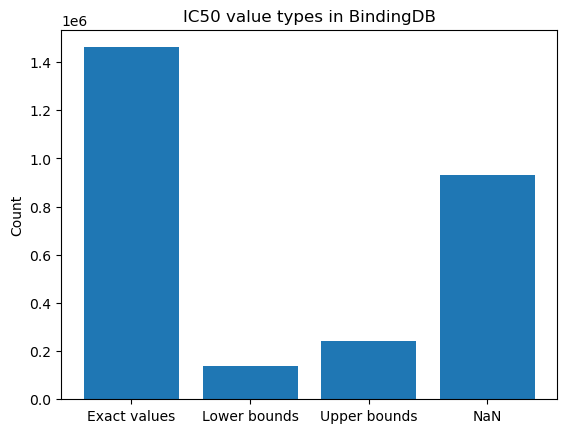

In [151]:
upper_bound_ic50_values = filtered_df[filtered_df['IC50 (nM)'].apply(lambda x: type(x)==str and '>' in x)]
lower_bound_ic50_values = filtered_df[filtered_df['IC50 (nM)'].apply(lambda x: type(x)==str and '<' in x)]
nan_ic50_values = filtered_df[filtered_df['IC50 (nM)'].isna()]
number_of_exact_ic50_values = len(filtered_df)-len(upper_bound_ic50_values)-len(lower_bound_ic50_values)-len(nan_ic50_values)
names = ['Exact values', 'Lower bounds', 'Upper bounds', 'NaN']
vals = [number_of_exact_ic50_values, len(lower_bound_ic50_values), len(upper_bound_ic50_values), len(nan_ic50_values)]
plt.bar(names, vals)
plt.ylabel('Count')
plt.title('IC50 value types in BindingDB');

We obviously have to drop rows with NaN IC50 values. This analysis also shows us that most entries have an exact IC50 values and it is thus valid to focus on those. 

In [152]:
def filter_out_comparator(s):
    if type(s)==str and ('>' in s or '<' in s):
        return False
    else:
        return True

clean_df = filtered_df.copy()
clean_df = clean_df[clean_df['IC50 (nM)'].apply(filter_out_comparator)]
clean_df['IC50 (nM)'] = pd.to_numeric(clean_df['IC50 (nM)'], errors='coerce')
clean_df = clean_df.dropna(subset=['IC50 (nM)'])
clean_df.head()

,Ligand SMILES,Target Name,IC50 (nM),BindingDB Target Chain Sequence,UniProt (SwissProt) Entry Name of Target Chain
BindingDB Reactant_set_id,,,,,
145,O=C1CCCC2=C1C1(CCS(=O)(=O)C1)N=C(Nc1nc3ccccc3o...,Galactokinase,6676.9,MAALRQPQVAELLAEARRAFREEFGAEPELAVSAPGRVNLIGEHTD...,GALK1_HUMAN
181,CC(C)[C@H](NC(C)=O)C(=O)N[C@@H](Cc1ccccc1)[C@@...,Dimer of Gag-Pol polyprotein [489-587],8.5,PQITLWQRPLVTIKIGGQLKEALLDTGADDTVLEEMNLPGRWKPKM...,POL_HV1N5
182,CCOC(=O)N[C@@H](C(C)C)C(=O)N[C@@H](Cc1ccccc1)[...,Dimer of Gag-Pol polyprotein [489-587],177.0,PQITLWQRPLVTIKIGGQLKEALLDTGADDTVLEEMNLPGRWKPKM...,POL_HV1N5
184,COCCOC(=O)N[C@@H](C(C)C)C(=O)N[C@@H](Cc1ccccc1...,Dimer of Gag-Pol polyprotein [489-587],164.0,PQITLWQRPLVTIKIGGQLKEALLDTGADDTVLEEMNLPGRWKPKM...,POL_HV1N5
185,COCCOCCOC(=O)N[C@@H](C(C)C)C(=O)N[C@@H](Cc1ccc...,Dimer of Gag-Pol polyprotein [489-587],67.0,PQITLWQRPLVTIKIGGQLKEALLDTGADDTVLEEMNLPGRWKPKM...,POL_HV1N5


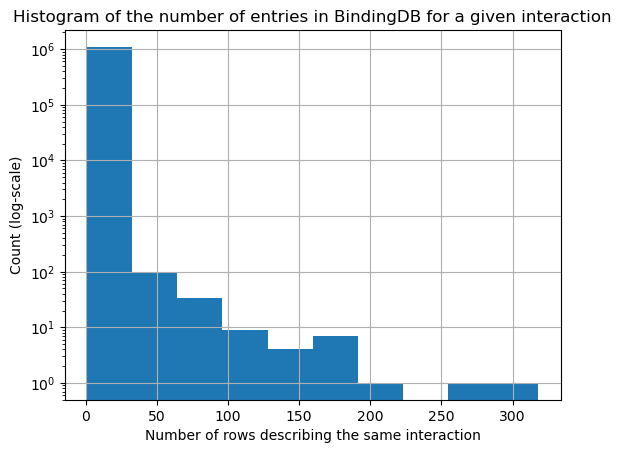

In [154]:
grouped_by_interactions = clean_df.groupby(['Ligand SMILES', 'Target Name', 'BindingDB Target Chain Sequence', 
                                            'UniProt (SwissProt) Entry Name of Target Chain'])['IC50 (nM)'].count().reset_index()
grouped_by_interactions['IC50 (nM)'].hist(log=True)
plt.title('Histogram of the number of entries in BindingDB for a given interaction')
plt.xlabel('Number of rows describing the same interaction')
plt.ylabel('Count (log-scale)');

This plot shows us that some interactions have multiple entries in BindingDB. We thus need to merge the values to have only one entry per interaction. To have a robust merged value, we have decided to use the median which is less sensitive to outliers compared to the mean. 
Once this is done, we save this dataframe into a csv file which contains all the processed data.

In [155]:
merged_df = clean_df.groupby(['Ligand SMILES', 'Target Name', 'BindingDB Target Chain Sequence', 
                              'UniProt (SwissProt) Entry Name of Target Chain'])['IC50 (nM)'].median().reset_index()
merged_df.to_csv('merged_df.csv')
merged_df.head()

,Ligand SMILES,Target Name,BindingDB Target Chain Sequence,UniProt (SwissProt) Entry Name of Target Chain,IC50 (nM)
0,B.CP(c1ccccc1)c1ccc(O)cc1,Estrogen receptor,MTMTLHTKASGMALLHQIQGNELEPLNRPQLKIPLERPLGEVYLDS...,ESR1_HUMAN,9800.0
1,B.CP(c1ccccc1)c1ccc(O)cc1,Estrogen receptor beta,MDIKNSPSSLNSPSSYNCSQSILPLEHGSIYIPSSYVDSHHEYPAM...,ESR2_HUMAN,2500.0
2,B.Oc1ccc(cc1)P(c1ccccc1)c1ccccc1,Estrogen receptor,MTMTLHTKASGMALLHQIQGNELEPLNRPQLKIPLERPLGEVYLDS...,ESR1_HUMAN,12000.0
3,B.Oc1ccc(cc1)P(c1ccccc1)c1ccccc1,Estrogen receptor beta,MDIKNSPSSLNSPSSYNCSQSILPLEHGSIYIPSSYVDSHHEYPAM...,ESR2_HUMAN,2000.0
4,B[P@@]1(=O)OC[C@H]2O[C@H]([C@@H](F)C2O[P@@](B)...,Stimulator of interferon genes protein [140-379],APAEISAVCEKGNFNVAHGLAWSYYIGYLRLILPELQARIRTYNQH...,STING_HUMAN,5470.0


Some parts of our study focuses only in mutants and we thus will process the data further to store this information in another file. 
First, we look at the distribution of the number of mutants for a given ligand and a given wild-type (WT) protein.
In BindingDB, two mutants will share the same 'UniProt (SwissProt) Entry Name of Target Chain' value but the 'Target Name' value will be different and indicate the type and location of mutations.

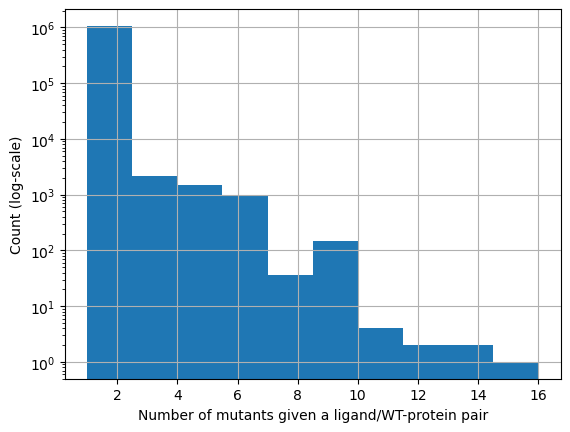

In [157]:
merged_df.groupby(['Ligand SMILES', 'UniProt (SwissProt) Entry Name of Target Chain']).count().reset_index()['Target Name'].hist(log=True)
plt.xlabel('Number of mutants given a ligand/WT-protein pair')
plt.ylabel('Count (log-scale)');

This histogram shows that most entries correspond to an interaction between a given ligand A and a given WT protein B where no mutants of B were tested against A. We thus have to filter out these interaction to focus on groups that have at least 2 values (the WT protein and a mutant)

In [209]:
mutants_filtered_df = merged_df.groupby(['Ligand SMILES', 'UniProt (SwissProt) Entry Name of Target Chain']).filter(lambda x: len(x) >= 2)
merged_mutants_filtered_df = mutants_filtered_df.groupby(['Ligand SMILES', 'UniProt (SwissProt) Entry Name of Target Chain']).apply(lambda x: pd.Series({
    'Target Names': list(x['Target Name']),
    'BindingDB Target Chain Sequence': list(x['BindingDB Target Chain Sequence'])}), include_groups=False).reset_index()
merged_mutants_filtered_df.head()

,Ligand SMILES,UniProt (SwissProt) Entry Name of Target Chain,Target Names,BindingDB Target Chain Sequence
0,Brc1cc(CN2CCC(CC2)N2CC(CC#N)(C2)n2cc(cn2)-c2nc...,JAK2_HUMAN,"[Tyrosine-protein kinase JAK2 [828-1132], Tyro...",[ALGFSGAFEDRDPTQFEERHLKFLQQLGKGNFGSVEMCRYDPLQD...
1,Brc1cc(CN2CCC(CC2)N2CC(CC#N)(C2)n2cc(cn2)-c2nc...,JAK2_HUMAN,"[Tyrosine-protein kinase JAK2 [828-1132], Tyro...",[ALGFSGAFEDRDPTQFEERHLKFLQQLGKGNFGSVEMCRYDPLQD...
2,Brc1ccc(\C=C\CNCCOc2cncc(\C=C\c3ccncc3)c2)cc1,AKT1_HUMAN,"[RAC-alpha serine/threonine-protein kinase, RA...",[MSDVAIVKEGWLHKRGEYIKTWRPRYFLLKNDGTFIGYKERPQDV...
3,Brc1ccc2OCc3noc(=O)n3-c2c1,PVDQ_PSEAE,"[Acyl-homoserine lactone acylase PvdQ, Acyl-ho...",[MGMRTVLTGLAGMLLGSMMPVQADMPRPTGLAADIRWTAYGVPHI...
4,Brc1ccc2n(CC(=O)NC3CN(C3)C(=O)C=C)cc(C(=O)N3CC...,RASK_HUMAN,"[GTPase KRas, GTPase KRas [1-169,G12C,C118A]]",[MTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVV...


For some analysis, we need to know which protein is the WT and which ones are the mutants. To do so, we query UniProt, retrieve the protein name using 'UniProt (SwissProt) Entry Name of Target Chain' and we check if the WT protein was tested against the given ligand. We filter out all the rows for which this is not the case since we can't perform any analysis if we don't have IC50 value for the WT against the given ligand.

In [211]:
def get_protein_name(entry_name):
    url = f"https://rest.uniprot.org/uniprotkb/{entry_name}.json"
    
    response = requests.get(url)
    
    # Check if the response was successful
    if response.status_code == 200:
        data = response.json()
        # Extract the protein name
        protein_name = data['proteinDescription']['recommendedName']['fullName']['value']
        return protein_name
    else:
        print(f"Entry '{entry_name}' not found or an error occurred.")
        return None
protein_names = {entry: get_protein_name(entry) for entry in merged_mutants_filtered_df['UniProt (SwissProt) Entry Name of Target Chain'].unique()}
merged_mutants_filtered_df['WT Target Name'] = merged_mutants_filtered_df.apply(lambda x: protein_names.get(x['UniProt (SwissProt) Entry Name of Target Chain'], None) 
                                 if protein_names.get(x['UniProt (SwissProt) Entry Name of Target Chain'], None) in x['Target Names'] else None, axis=1)
merged_mutants_filtered_df.dropna(subset=['WT Target Name'], inplace=True)
merged_mutants_filtered_df.head()


,Ligand SMILES,UniProt (SwissProt) Entry Name of Target Chain,Target Names,BindingDB Target Chain Sequence,WT Target Name
2,Brc1ccc(\C=C\CNCCOc2cncc(\C=C\c3ccncc3)c2)cc1,AKT1_HUMAN,"[RAC-alpha serine/threonine-protein kinase, RA...",[MSDVAIVKEGWLHKRGEYIKTWRPRYFLLKNDGTFIGYKERPQDV...,RAC-alpha serine/threonine-protein kinase
3,Brc1ccc2OCc3noc(=O)n3-c2c1,PVDQ_PSEAE,"[Acyl-homoserine lactone acylase PvdQ, Acyl-ho...",[MGMRTVLTGLAGMLLGSMMPVQADMPRPTGLAADIRWTAYGVPHI...,Acyl-homoserine lactone acylase PvdQ
4,Brc1ccc2n(CC(=O)NC3CN(C3)C(=O)C=C)cc(C(=O)N3CC...,RASK_HUMAN,"[GTPase KRas, GTPase KRas [1-169,G12C,C118A]]",[MTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVV...,GTPase KRas
5,Brc1ccc2n(CC(=O)NC3CN(C3)C(=O)C=C)cc(C(=O)NCCc...,RASK_HUMAN,"[GTPase KRas, GTPase KRas [1-169,G12C,C118A]]",[MTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVV...,GTPase KRas
6,Brc1ccc2n(CC(=O)NC3CN(C3)C(=O)C=C)cc(C(=O)NCc3...,RASK_HUMAN,"[GTPase KRas, GTPase KRas [1-169,G12C,C118A]]",[MTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVV...,GTPase KRas


In [212]:
merged_mutants_filtered_df.to_csv('mutants_24_11_10_only_exact_values.csv')

## 3. Ligand Analysis

## 4. Protein Analysis

In [ ]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
merged_data_path = '../data_nov_10th/merged_df_24_11_10_only_exact_values.csv'
merged_data_path = '../data/merged_df.csv'

## 4.0. Importing Data

In [ ]:
df_merged = pd.read_csv(merged_data_path)

In [ ]:
# Performing a copy of the dataset and showing columns information
df = df_merged.copy(deep=True)
df.info()

## 4.1. Preprocessing

### 4.1.1 Grouping by Protein Group
 goal is to read the "Target Name" entry of each protein to try to label the protein in the major Groups (e.g. kinase, receptor, etc.)

In [ ]:
# Precompile regular expressions and organize them in a dictionary to improve search efficiency
categories = {
    "Kinase": re.compile(r'kinase|akt|mapk|cdk|jak|trk|src'),
    "Receptor": re.compile(r'receptor|gpcr|serotonin|dopamine|glutamate|adrenergic|opioid'),
    "Synthase": re.compile(r'synthase|synthetase|carboxylase|dehydratase'),
    "Ligase": re.compile(r'ligase|carboxylase|dna ligase'),
    "Oxidase": re.compile(r'oxidase|oxygenase|peroxidase|cytochrome'),
    "Transferase": re.compile(r'transferase|methyltransferase|phosphotransferase|acetyltransferase'),
    "Hydrolase": re.compile(r'hydrolase|phosphatase|protease|lipase|esterase|nuclease'),
    "Enzyme": re.compile(r'enzyme|dehydrogenase|isomerase|lyase'),
    "Ion Channel": re.compile(r'channel|ion channel|potassium|sodium|calcium|chloride'),
    "Transporter": re.compile(r'transporter|abc transporter|slc transporter|solute carrier'),
    "Chaperone": re.compile(r'chaperone|heat shock protein|hsp'),
    "Structural Protein": re.compile(r'actin|tubulin|collagen|elastin'),
    "Signaling Protein": re.compile(r'g-protein|adapter protein|scaffold protein'),
    "Antibody": re.compile(r'antibody|immunoglobulin|igg|igm|iga'),
    "Transcription Factor": re.compile(r'transcription factor|p53|nf-kb|homeobox|hox|forkhead'),
    "Growth Factor / Cytokine": re.compile(r'growth factor|cytokine|interleukin|tnf|vegf|egf|fgf'),
    "Protease Inhibitor": re.compile(r'protease inhibitor|serpin'),
    "Hormone": re.compile(r'hormone|insulin|glucagon|erythropoietin|epo'),
    "Viral Replicase Polyprotein": re.compile(r'replicase polyprotein 1ab|replicase polyprotein 1a'),
    "Viral Genome Polyprotein": re.compile(r'genome polyprotein'),
    "Huntingtin": re.compile(r'huntingtin')
}

# Function to categorize based on precompiled regex patterns
def categorize_targets(name):
    """
    Categorizes each protein into a group based on its name
    :param name (str): target protein name
    :return: the category the protein has been labeled 
    """
    name = name.lower()
    for category, pattern in categories.items():
        if pattern.search(name):
            return category
    return "Other"

# Creating a new column in the dataframe
df['Protein Group'] = df['Target Name'].apply(categorize_targets)

# Get counts by category
target_counts = df['Protein Group'].value_counts()
print(target_counts)


### 4.1.2 Identifying Unlabelled Proteins

In [ ]:
df[df['Protein Group']== 'Other'][['Target Name', 'UniProt (SwissProt) Entry Name of Target Chain', 'Protein Group',]].sample(10)

### 4.1.3 Registering Protein Amino Acid Sequence Length

In [ ]:
df['target_chain_length'] = df['BindingDB Target Chain Sequence'].str.len()

## 4.2. Plotting Explorations

### 4.2.1 Creating custom color maps for plotting purposes
The Group "Other" (unclassified proteins) is assigned the lightgrey color for visualization purposes

In [ ]:
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches

# Retrieve the target families and then create a custom colormap
target_group = df['Protein Group'].astype('category').cat.categories
index_other = target_group.get_loc('Other')
colors = plt.cm.viridis(np.linspace(0, 1, len(target_group)))
colors[index_other] = mcolors.to_rgba('lightgrey')  # Set the color for "Other" to lightgrey

# Create the custom colormap based on the parameters defined above
custom_cmap = mcolors.ListedColormap(colors)
color_dict = {group: color for group, color in zip(target_group, colors)}

# Manual legend creation using patches for each target group
patches = [mpatches.Patch(color=colors[i], label=target_group[i]) for i in range(len(target_group))]

### 4.2.2 Histogram of Target Chain Lengths grouped by Target Group

In [ ]:
plt.figure(figsize=(10, 7))

# Variant A) PLotting that respects the alphabetical order
sns.histplot(data=df, x='target_chain_length', bins=10, hue='Protein Group', multiple='dodge', palette=color_dict, hue_order = color_dict.keys())

# Variant B) Plotting that respects the frequency order
#sns.histplot(data=df, x='target_chain_length', bins=10, hue='target_group', multiple='dodge', palette=color_dict)

plt.title('Histogram of Target Chain Lengths by Target Group')
plt.xlabel('Target Chain Length')
plt.ylabel('Counts')
plt.show()

### 4.2.3 IC50 vs Target Chain Length

In [ ]:
fig, ax = plt.subplots(figsize=(15, 7))

# Scatter plot with the custom colormap
scatter = ax.scatter(data=df, x='target_chain_length', y='IC50 (nM)',
                     c=df['Protein Group'].astype('category').cat.codes, cmap=custom_cmap)

ax.legend(handles=patches, title="Target Group", loc="upper right")

# Changing scales for plotting purposes
#ax.set_xscale('log')
ax.set_xlim([0, 1e4])
ax.set_yscale('log')

plt.title('Scatter Plot: IC50 vs Target Chain Length')
plt.xlabel('Target Chain Length')
plt.ylabel('IC50 (nm)')
plt.show()

### 4.2.3 Boxplots IC50 or Protein Length in each Target Group

#### 4.2.3.A IC50

In [ ]:
# Log-transform IC50 values for better scaling
df['Log_IC50 (nM)'] = np.log10(df['IC50 (nM)'])

plt.figure(figsize=(12, 8))

# Boxplot => Log_transformed IC50
sns.boxplot(
    data=df, x='Protein Group', y='Log_IC50 (nM)',
    order=color_dict.keys(), palette=color_dict, hue='Protein Group'
)

# Plotting param
plt.xticks(rotation=90)
plt.xlabel("Protein Group")
plt.ylabel("Log10 IC50 (nM)")
plt.title("Distribution of IC50 (nM) by Protein Group (Log Scale)")
plt.tight_layout()  # Used to avoid label overlap

plt.show()

#### 4.2.4.B Protein Length

In [ ]:
plt.figure(figsize=(12, 8))

# Boxplot => Protein Length
sns.boxplot(
    data=df, x='Protein Group', y='target_chain_length',
    order=color_dict.keys(), palette=color_dict, hue='Protein Group'
)

# Plotting param
plt.xticks(rotation=90)
plt.xlabel("Protein Group")
plt.ylabel("Protein Length")
plt.title("Distribution of Protein Length by Protein Group")
plt.tight_layout()  # Used to avoid label overlap

plt.show()

Quantile transformation to compress long protein lengths that are less frequent

In [ ]:
from sklearn.preprocessing import QuantileTransformer

transformer = QuantileTransformer(output_distribution='normal')
df['Quantile_length'] = transformer.fit_transform(df[['target_chain_length']])

plt.figure(figsize=(12, 8))

# Boxplot => Quantile-Transformed Protein Length
sns.boxplot(
    data=df, x='Protein Group', y='Quantile_length',
    order=color_dict.keys(), palette=color_dict, hue='Protein Group'
)

# Plotting param
plt.xticks(rotation=90)
plt.xlabel("Protein Group")
plt.ylabel("Protein Length")
plt.title("Quantile-Transformed Distribution of Protein Length by Protein Group")
plt.tight_layout()  # Used to avoid label overlap

plt.show()